In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import models
from comet_ml import Experiment
%matplotlib inline

In [2]:
experiment = Experiment(api_key="dZm2UV8sODS5eDYysEf8TzKNu", project_name="cart")

COMET WARNING: We detected that you are running inside a Ipython/Jupyter notebook environment but we cannot save your notebook source code. Please be sure to have installed comet_ml as a notebook server extension by running:
jupyter comet_ml enable
COMET INFO: old comet version (1.0.9) detected. current: 1.0.10 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Comet.ml support for Ipython Notebook is limited at the moment, automatic monitoring and stdout capturing is deactivated
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/syrios/cart/261a99286b3b4e5784eb138afac43c05



In [3]:
#env = gym.make("Pong-v0")
env = gym.make('CartPole-v0').unwrapped

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).cuda()

## Replay Memory

Store transitions that the agent observes so can be re-used later. By sampling from this randomly improves stability

In [5]:
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.65
EPS_END = 0.1
EPS_DECAY = 100000 + 1000
TARGET_UPDATE = 1000
n_frames_min = 2000000
SAVE_EVERY = 250
REPLAY_SIZE = 100000
LR = 1e-4
BURN_IN = 1000
model_save_name = "./models/cart_dqn_policy6.state"
start_from_trained = True
trained_model = "./models/cart_dqn_policy5.state"
N_ACTIONS = 2

experiment.log_parameter("batch size", BATCH_SIZE)
experiment.log_parameter("gamma", GAMMA)
experiment.log_parameter("eps start", EPS_START)
experiment.log_parameter("eps end", EPS_END)
experiment.log_parameter("eps decay", EPS_DECAY)
experiment.log_parameter("target update", TARGET_UPDATE)
experiment.log_parameter("min frames", n_frames_min)
experiment.log_parameter("start trained", start_from_trained)
experiment.log_parameter("replay size", REPLAY_SIZE)
experiment.log_parameter("learning rate", LR)
experiment.log_parameter("burn in", BURN_IN)


# the policy network is used to play the game - aka actor
policy_net = models.DQN().cuda()
if start_from_trained:
    policy_net.load_state_dict(torch.load(trained_model))

# the target net is used to predict Q values for next action
# we need 2 otherwise we would be using the same network
# in the actual and predicted values of our loss function
target_net = models.DQN().cuda()
target_net.load_state_dict(policy_net.state_dict())
# sets training to false 
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(REPLAY_SIZE)

steps_done = 0

def select_action(state):
    global steps_done
    # gen random number
    sample = random.random()
    # get threshold which decays from start to end 
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # if exceed, pick best
    if sample > eps_threshold:
        # No gradients b/c not learning, just getting best one
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1), eps_threshold
    # else, random
    else:
        return torch.tensor([[random.randrange(2)]], device='cuda', 
                            dtype=torch.long), eps_threshold  

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE or len(memory) < BURN_IN:
        return None
    
    transitions = memory.sample(BATCH_SIZE)
    # transpose the batch...
    batch = Transition(*zip(*transitions))
    # compute mask of transitions which didn't lead to ending game
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device="cuda", dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # calculate the Q value of taking the state, action pairs which were taken
    # the gather basically takes the Q value for the action choosen
    # So if my input choose action 3 for the given state, that is what I would gather.
    # Basically, what is the Q value for what actually happened
    # Q value being the total expected value from taking an action given a state.
    # These are basically our predictions for learning
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE).cuda()
    # get the best actions for the next states
    # detach is for speed so don't calc gradients
    target_net_results = target_net(non_final_next_states).max(1)[0].detach()
    next_state_values[non_final_mask] = target_net_results
    # the expected value of the Q(s,a) given from the policy net is the
    # reward given plus the discounted value of the Q value from taking the best
    # action at the next step
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, 
                            expected_state_action_values.unsqueeze(1))
    
    # Optimize the policy net to become better and predicting Q values
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

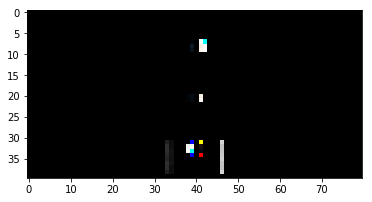

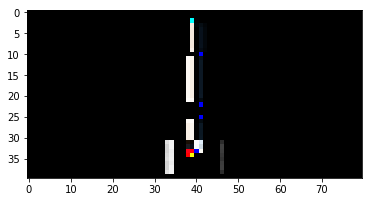

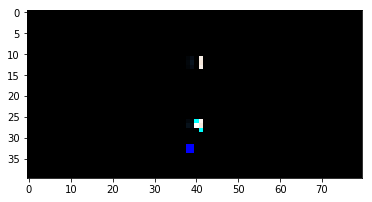

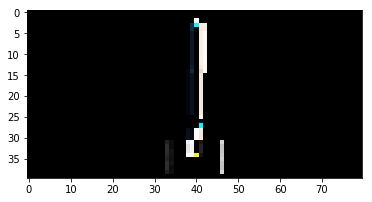

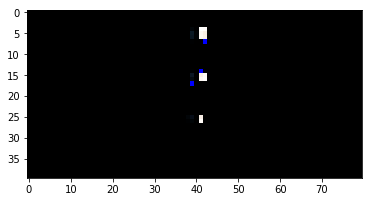

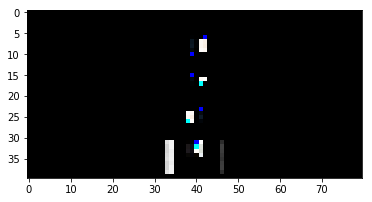

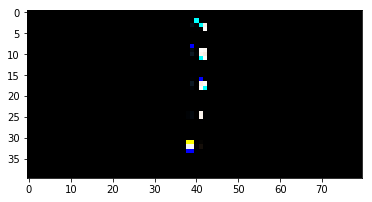

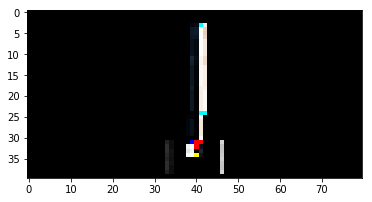

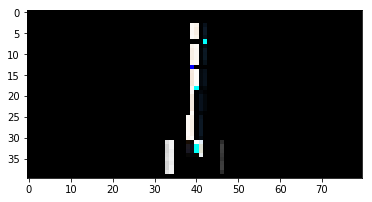

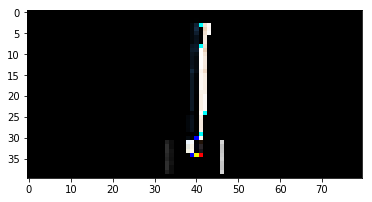

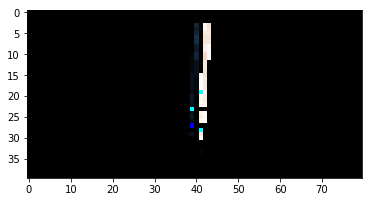

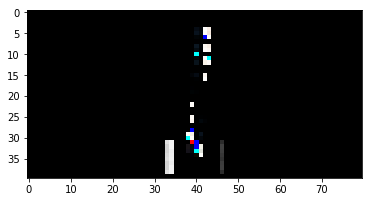

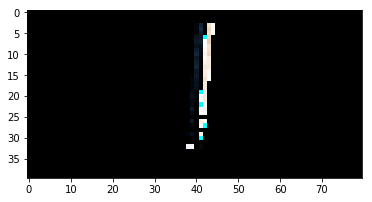

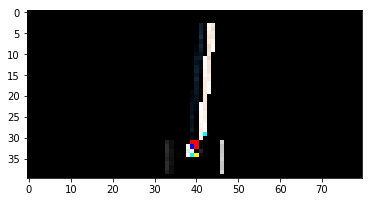

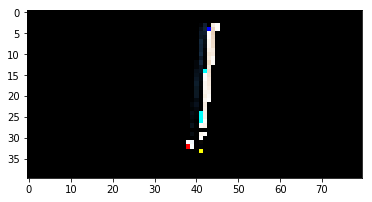

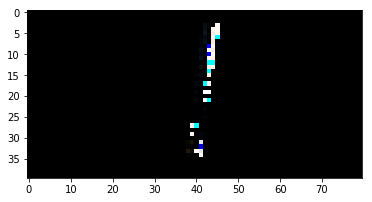

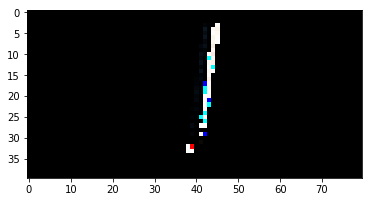

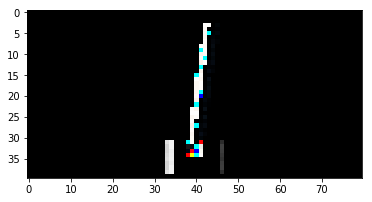

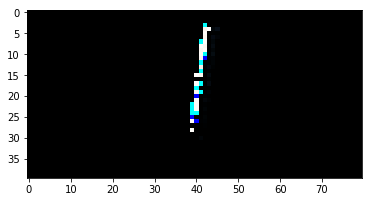

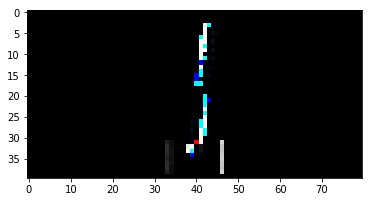

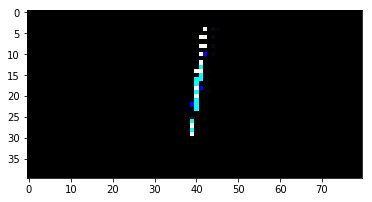

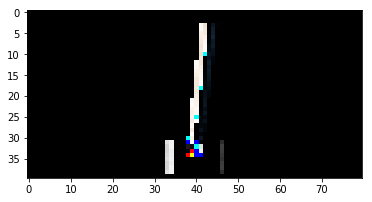

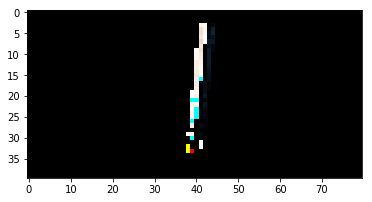

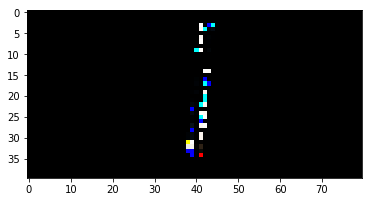

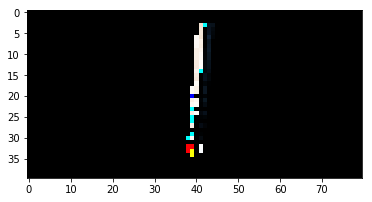

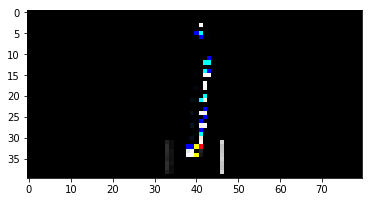

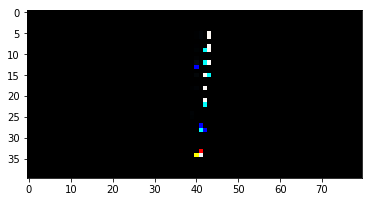

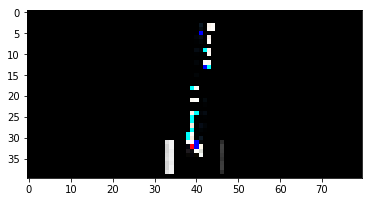

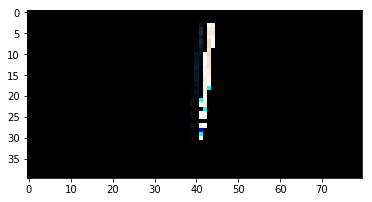

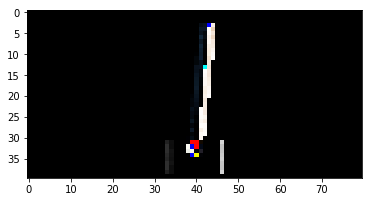

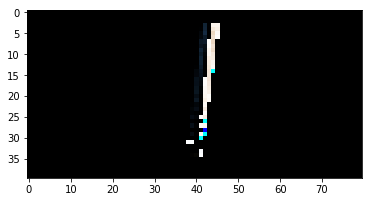

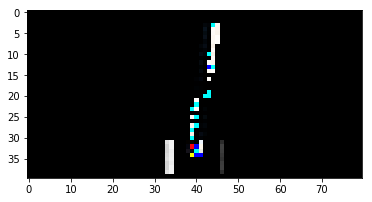

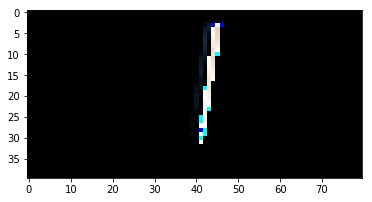

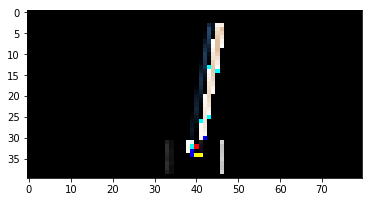

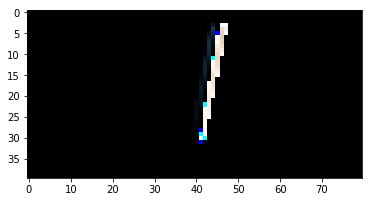

AttributeError: 'NoneType' object has no attribute 'cpu'

In [8]:
running_reward = None
reward_sum = 0
n_frames = 0
i_episode = 0
while n_frames < n_frames_min:
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    prev_state = None
    losses = []
    for t in count():
         
        action, eps_threshold = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward_sum += reward
        reward = torch.tensor([reward])
        reward = reward.cuda()
        
        last_screen = current_screen
        current_screen = get_screen()

        n_frames += 1
        if n_frames % TARGET_UPDATE == 0:
            print("Frame: {}".format(n_frames))
            target_net.load_state_dict(policy_net.state_dict())
        
        
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        plt.imshow(next_state.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
        plt.show()
            
        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        if done:
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            experiment.log_metric("reward sum", reward_sum, step=i_episode)
            reward_sum = 0
            experiment.log_metric("reward mean", running_reward, step=i_episode)
            experiment.log_metric("eps", eps_threshold, step=i_episode)
            i_episode += 1
            break

    if i_episode % SAVE_EVERY == 0:
        print("Episode: {}".format(i_episode))
        print("Saving Model...")
        torch.save(policy_net.state_dict(), model_save_name)

In [ ]:
torch.save(policy_net.state_dict(), model_save_name)